In [2]:
library(tidymodels)
library(readxl)
library(lubridate)



car_data <- read_xlsx("Data Viz Assignment_ Carbitrage Data.xlsx")

Warning message:
"package 'tidymodels' was built under R version 4.3.3"
── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.5      ✔ recipes      1.0.10
✔ dials        1.2.1      ✔ rsample      1.2.1 
✔ dplyr        1.1.4      ✔ tibble       3.2.1 
✔ ggplot2      3.5.0      ✔ tidyr        1.3.1 
✔ infer        1.0.7      ✔ tune         1.2.0 
✔ modeldata    1.3.0      ✔ workflows    1.1.4 
✔ parsnip      1.2.1      ✔ workflowsets 1.1.0 
✔ purrr        1.0.2      ✔ yardstick    1.3.1 

Warning message:
"package 'dials' was built under R version 4.3.3"
Warning message:
"package 'scales' was built under R version 4.3.3"
Warning message:
"package 'dplyr' was built under R version 4.3.3"
Warning message:
"package 'ggplot2' was built under R version 4.3.3"
Warning message:
"package 'infer' was built under R version 4.3.3"
Warning message:
"package 'modeldata' was built under R version 4.3.3"
Warning message:
"package 'parsnip' was built under 

`summarise()` has grouped output by 'make'. You can override using the
`.groups` argument.


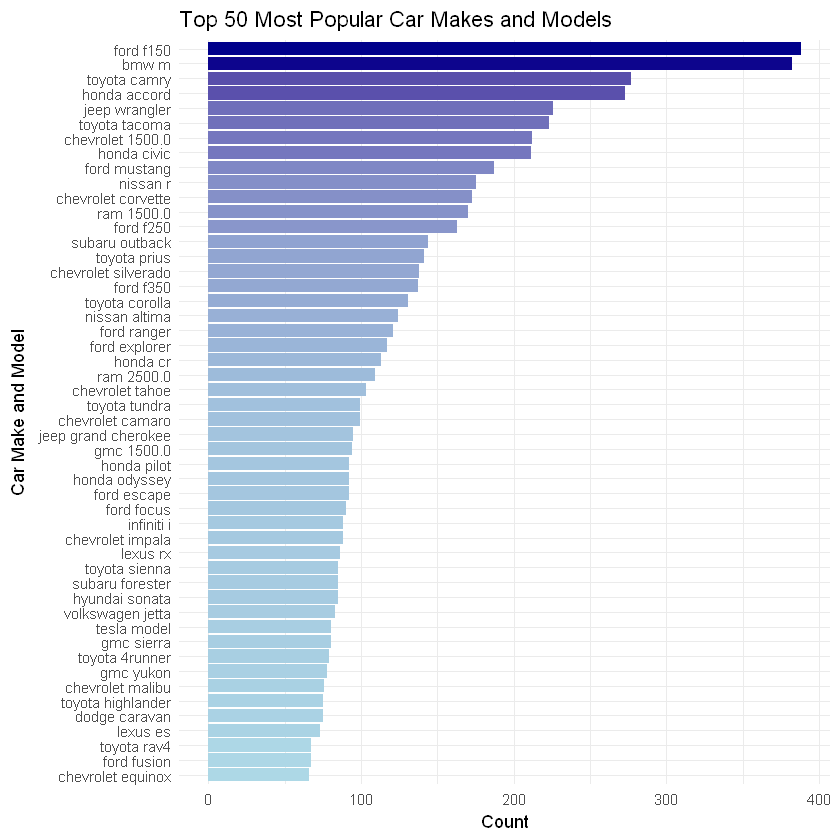

In [3]:
cleaned_data <- recipe(~., data = car_data) %>%
    step_naomit(all_predictors()) %>%
    prep() %>%
    juice()


# First Visuzalizations
data_for_viz = cleaned_data %>%
    group_by(make, model) %>%
    summarise(count = n()) %>%
    arrange(desc(count))


top_car_counts <- head(data_for_viz, 50)

ggplot(data = top_car_counts, aes(y = reorder(paste(make, model), count), x = count, fill = count)) +
    geom_bar(stat = "identity") +
    scale_fill_gradient(low = "lightblue", high = "darkblue") +
    theme_minimal() +
    labs(y = "Car Make and Model", x = "Count", title = "Top 50 Most Popular Car Makes and Models") +
    theme(legend.position = "none")


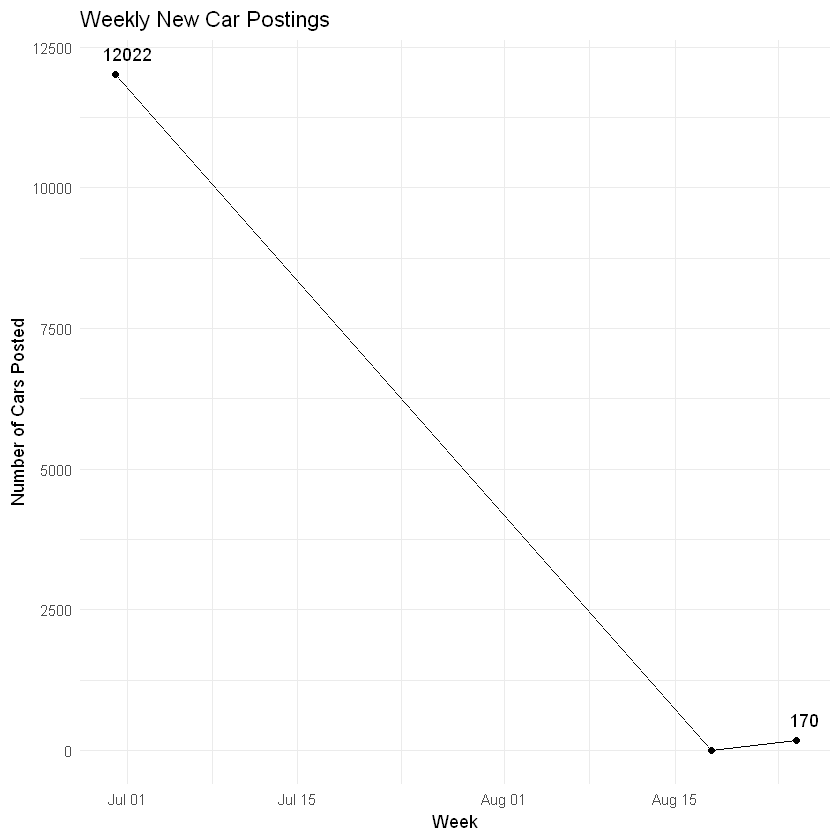

In [7]:

cleaned_data2 <- cleaned_data

cleaned_data2$time_posted <- as.Date(cleaned_data$time_posted)



# daily_plot <- cleaned_data2 %>%
#     group_by(time_posted) %>%
#     summarise(Count = n()) %>%
#     ggplot(aes(x = time_posted, y = Count)) +
#     geom_line() +
#     theme_minimal() +
#     labs(x = "Date", y = "Frequency", title = "Postings Per Day") +
#     geom_text(aes(label = ifelse(time_posted == as.Date("2024-07-03"), Count, "")), vjust = -1, hjust = 1) +
#     geom_point(aes(x = time_posted, y = Count))

# daily_plot

weekly_data <- cleaned_data2 %>%
    mutate(week = floor_date(time_posted, unit = "week")) %>% # Create a new 'week' column by rounding dates to the start of the week
    group_by(week) %>%
    summarise(Count = n())

ggplot(data = weekly_data, aes(x = week, y = Count)) +
    geom_line() +
    labs(title = "Weekly New Car Postings", x = "Week", y = "Number of Cars Posted") +
    geom_text(aes(label = ifelse(week == as.Date("2024-06-30") | week == as.Date("2024-08-25"), Count, "")), vjust = -1, hjust = .25) +
    geom_point(aes(x = week, y = Count)) +
    theme_minimal()

`summarise()` has grouped output by 'location'. You can override using the
`.groups` argument.


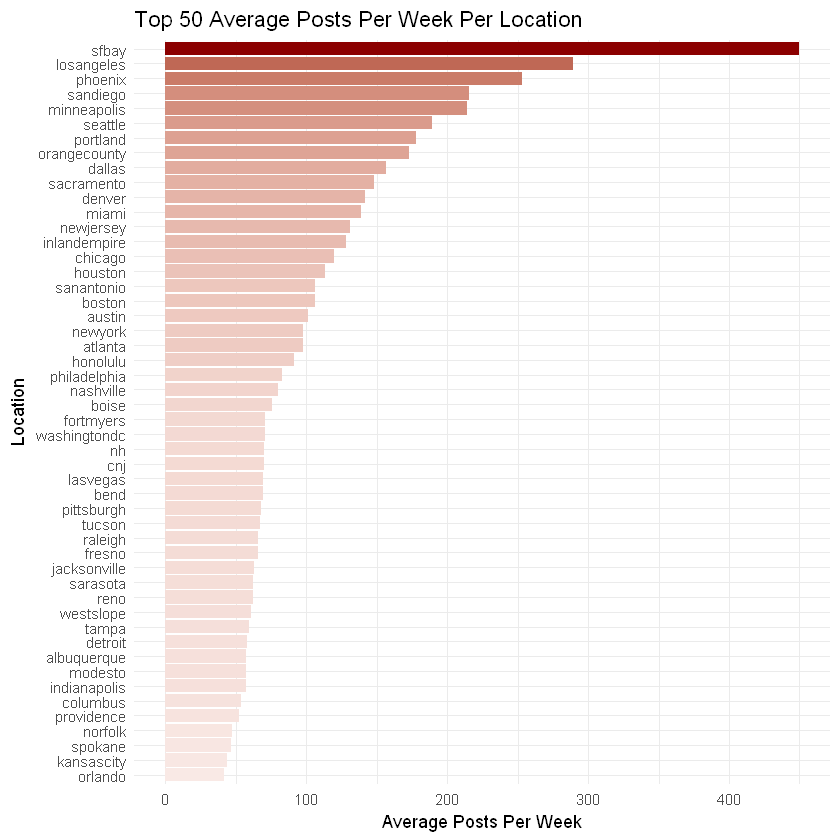

In [5]:
location_data = cleaned_data2 %>%
    mutate(week = floor_date(time_posted, unit = "week")) %>%
    group_by(location,week) %>%
    summarise(count = n())

location_data_50 = location_data %>%
    group_by(location) %>%
    summarise(avg = mean(count)) %>%
    arrange(desc(avg)) %>%
    head(50)



ggplot(data = location_data_50, aes(x = avg, y = reorder(location, avg), fill = avg)) +
    geom_bar(stat = "identity") +
    scale_fill_gradient2(low = "orange", high = "darkred") +
    theme_minimal() +
    theme(legend.position = "none") +
    labs(y = "Location", x = "Average Posts Per Week", title = "Top 50 Average Posts Per Week Per Location" )

`summarise()` has grouped output by 'location'. You can override using the
`.groups` argument.


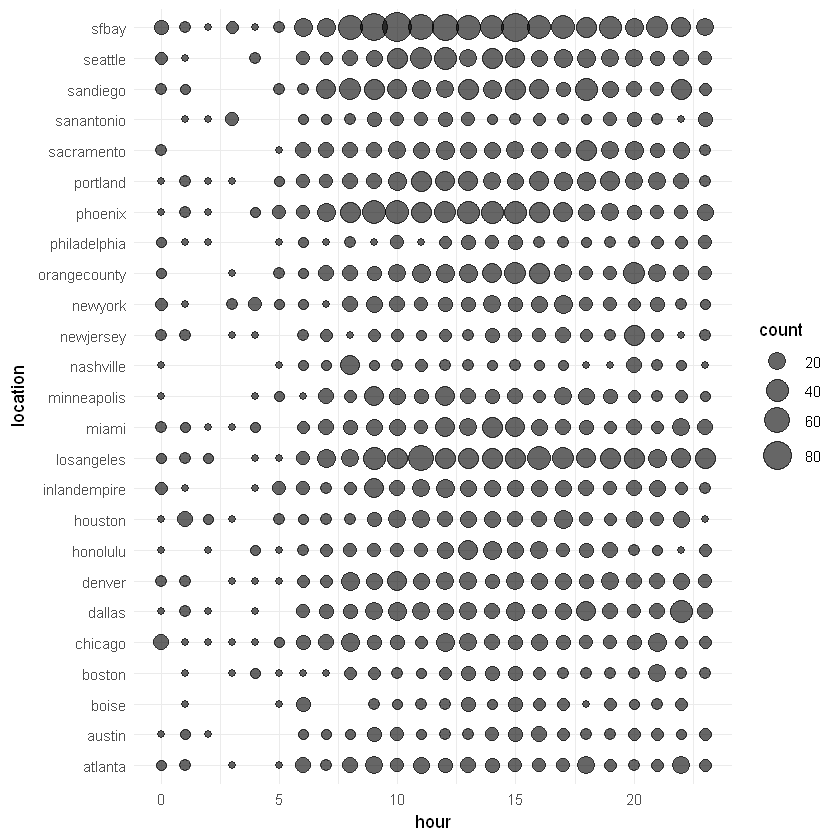

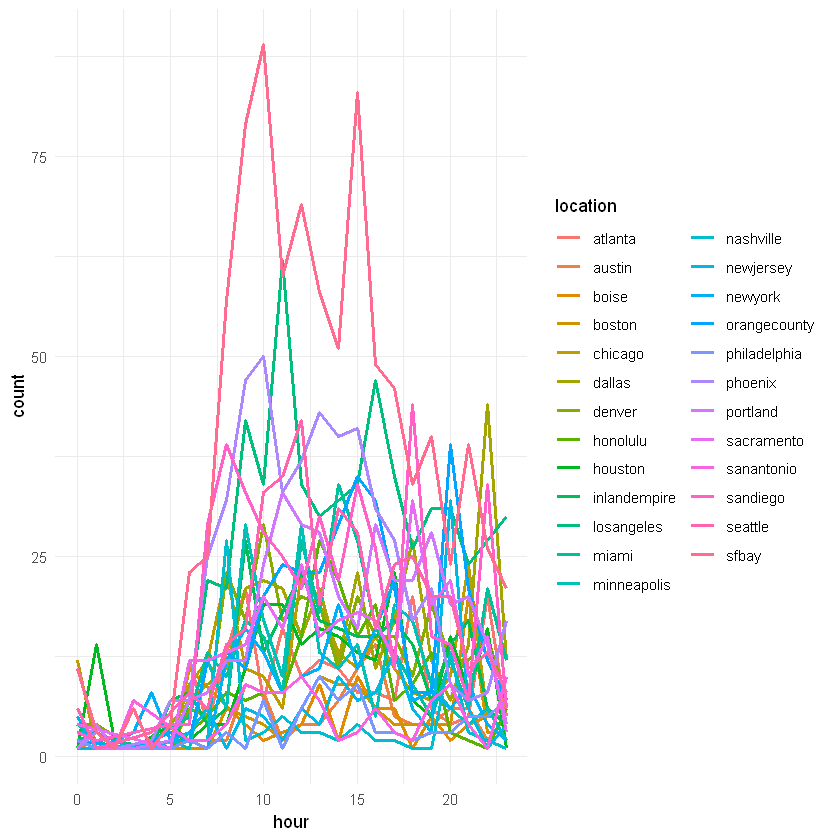

In [6]:
fourth_viz_data = cleaned_data

fourth_viz_data$time_posted = as.POSIXct(cleaned_data$time_posted, format = "%Y-%m-%d %H:%M:%S", tz = "UTC")

location_data_25 <- location_data %>%
    group_by(location) %>%
    summarise(avg = mean(count)) %>%
    arrange(desc(avg)) %>%
    head(25)


fourth_viz_data = fourth_viz_data %>%
    mutate(hour = hour(time_posted)) %>%
    filter(location %in% location_data_25$location)

fourth_viz_data = fourth_viz_data %>%
    group_by(location, hour) %>%
    summarise(count = n()) %>%
    ungroup()


ggplot(data = fourth_viz_data, aes(y = location, x = hour, size = count)) +
    geom_point(alpha = 0.6) +
    scale_size_continuous(range = c(2, 8)) +
    theme_minimal()




ggplot(data = fourth_viz_data, aes(y = count, x = hour, group = location, color = location)) +
    geom_line(linewidth = 1)+
    theme_minimal()
